### **Program for noise Analysis in LVIS data**  
**Author: Ramesh Bhatta, RIT**  
**Data: LVIS 2023 Bioscape collect**

In [1]:
## Importing libraries

import h5py
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, ifftshift

In [2]:
## Pred-defined figure sizes

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

In [3]:
# Import LVIS data- 350000 waveforms per dataset: We will use the noise statistics of these waveforms 
# Download your own set of data and import as follows:

file_names = ['LVISF1B_BioSCape2023_1115_R2404_045701.h5'] ## Add any number of files here

**A brief explanation of each key, based on LVIS WLiDAR data (HDf5 (level 1B Product) ):**

- `AZIMUTH`: The azimuth angle at which the LiDAR data was collected.
- `INCIDENTANGLE`: The angle at which the LiDAR pulse hit the surface.
- `LAT0`, `LAT1023`: The latitude at the start (`LAT0`)(highest sample) and end (`LAT1023`)(lowest sample) of the waveform.
- `LFID`: A unique identifier for each LiDAR footprint.
- `LON0`, `LON1023`: The longitude at the start (`LON0`)(highest sample) and end (`LON1023`)(lowest sample) of the waveform.
- `RANGE`: The distance from the LiDAR sensor to the ground.
- `RXWAVE`: The received waveform, i.e., the signal that was returned to the sensor after being reflected off the surface.
- `SHOTNUMBER`: A unique identifier for each LiDAR pulse.
- `SIGMEAN`: Signal mean noise level, calculated in-flight.
- `TIME`: The time at which each LiDAR pulse was emitted(UTC decimal seconds of the day).
- `TXWAVE`: The transmitted waveform, i.e., the signal that was emitted by the sensor.
- `Z0`, `Z1023`: The elevation at the start (`Z0`)(highest sample) and end (`Z1023`)(lowest sample) of the waveform.
- `ancillary_data`: Additional data that doesn't fit into the other categories.

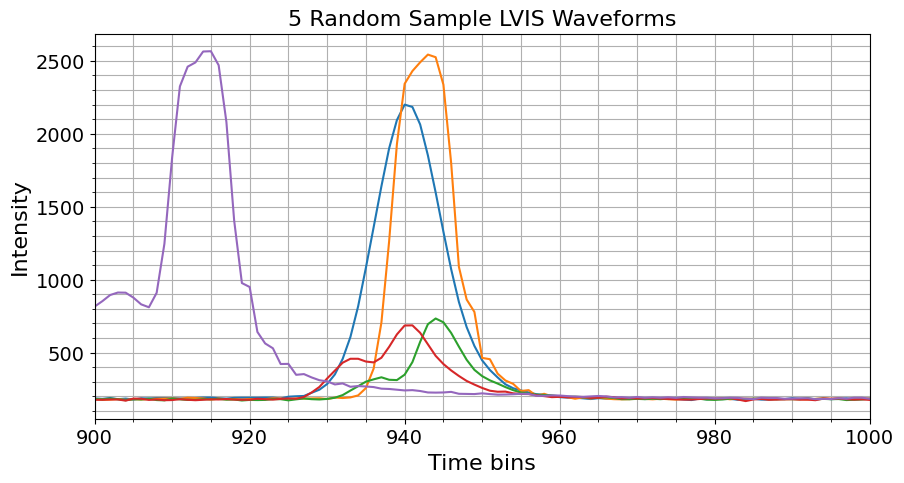

In [4]:
## Visualizing few sample waveforms

# Open the HDF file
lvis_sample1_hdf = h5py.File(file_names[0], 'r+')

# Extract the 'RXWAVE' data
rxwave = lvis_sample1_hdf['RXWAVE']
mean_noise = lvis_sample1_hdf['SIGMEAN']

# Selecting n random waveforms from the dataset to visualize
n = 5  # Number of random waveforms
indices = random.sample(range(len(rxwave)), n)

# Create a new figure
plt.figure(figsize=(10, 5))

# Loop over the selected indices and plot the corresponding waveforms
for i in indices:
    plt.plot(rxwave[i])

# Add grid, labels, and title
plt.grid(which='both')
plt.minorticks_on()
plt.xlabel('Time bins')
plt.ylabel('Intensity')
plt.xlim(900, 1000)
plt.title(f'{n} Random Sample LVIS Waveforms')

# Show the plot
plt.show()

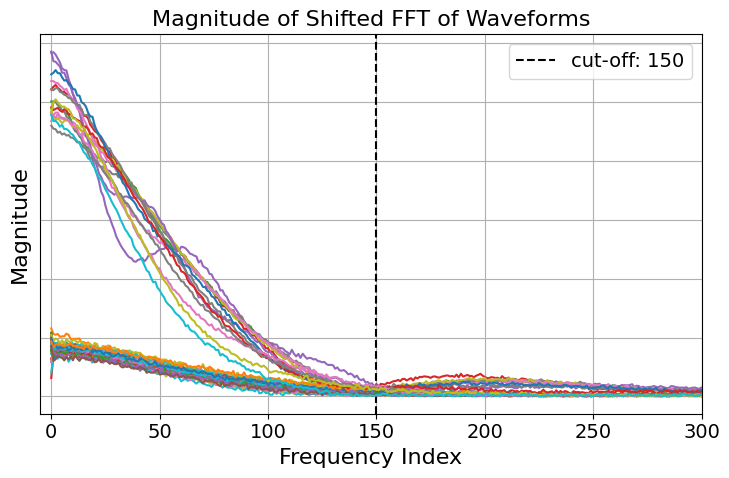

In [5]:
## 1.  Using frequency Distribution of few  random waveforms to select a cutt-off frequency for denoising

# Define the number of waveforms to collect from each dataset
num_waveforms = 50

plt.figure(figsize=(8, 5))  
ax = plt.subplot(1, 1, 1)  

for file_counter, file_name in enumerate(file_names):
    with h5py.File(file_name, 'r') as f:
        rxwave = f['RXWAVE'][:num_waveforms]
        sigmean = f['SIGMEAN'][:num_waveforms]

    for i in range(num_waveforms):
        
        # Select the waveform
        waveform = rxwave[i]

        # Get the SIGMEAN level
        sigmean_level = sigmean[i]

        # Subtract the SIGMEAN level from the waveform
        waveform_zeroed = waveform - sigmean_level

        # Convert the waveform to the frequency domain using FFT
        waveform_fft = fft(waveform_zeroed)

        # Shift the FFT output
        waveform_fft_shifted = fftshift(waveform_fft)

        # Get the positive half of the spectrum
        half_index = len(waveform_fft_shifted) // 2

        # Plot the magnitude of the shifted FFT
        ax.plot(np.abs(waveform_fft_shifted[half_index:]))
        

        # Add the vertical line and its label
        if file_counter == 0 and i == 0:
            ax.axvline(150, color='black', linestyle='dashed', label='cut-off: 150')

# Set the title, labels, and legend
ax.set_title('Magnitude of Shifted FFT of Waveforms')
ax.set_xlabel('Frequency Index')
ax.set_ylabel('Magnitude')

# Add the legend
ax.legend()
plt.tight_layout()
plt.grid(which='both')
plt.gca().set_yticklabels([])  # Remove y-axis tick labels
plt.gca().tick_params(axis='y', which='both', length=0)  # Remove y-axis tick marks
plt.xlim(-5, 300)
plt.show()

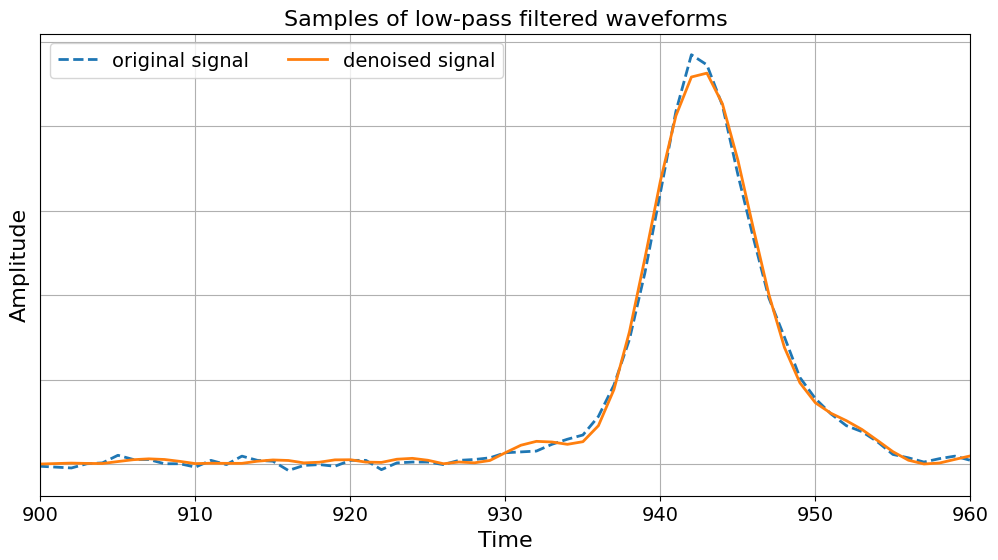

In [6]:
## 2. Using Low pass filter to denoise the waveforms: Sample Visualization

# Define the number of waveforms to collect from each dataset
num_waveforms = 1

# Initialize a list to store the noise values
noise_values = []

# Define the cut-off frequency Index
cut_off = 150

plt.figure(figsize=(12, 6))

for file_name in file_names:
    with h5py.File(file_name, 'r') as f:
        rxwave = f['RXWAVE'][:num_waveforms]
        sigmean = f['SIGMEAN'][:num_waveforms]

    for i in range(num_waveforms):
        # Select the waveform
        waveform = rxwave[i]

        # Get the SIGMEAN level
        sigmean_level = sigmean[i]

        # Subtract the SIGMEAN level from the waveform
        waveform_zeroed = waveform - sigmean_level

        # Convert the waveform to the frequency domain using FFT
        waveform_fft = fft(waveform_zeroed)

        # Zero out the FFT coefficients above the cut-off frequency
        waveform_fft[cut_off:-cut_off] = 0

        # Convert the filtered FFT back to the time domain using the inverse FFT
        waveform_filtered = ifft(waveform_fft)

        # Calculate the noise waveform
        noise_waveform = waveform_zeroed - waveform_filtered

        # Append the noise values to the list
        noise_values.extend(noise_waveform.real)

        # Plot the filtered waveform
        if i==0:
            plt.plot(waveform_zeroed, label = 'original signal', linewidth = 2, linestyle = 'dashed')
            plt.plot(np.abs(waveform_filtered), label = 'denoised signal', linewidth = 2)
        else:
            break

# Set the title and labels
plt.title('Samples of low-pass filtered waveforms')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='both')
plt.gca().set_yticklabels([]) 
plt.gca().tick_params(axis='y', which='both', length=0)  
plt.xlim(900, 960)
plt.legend(ncols=2)
plt.show()

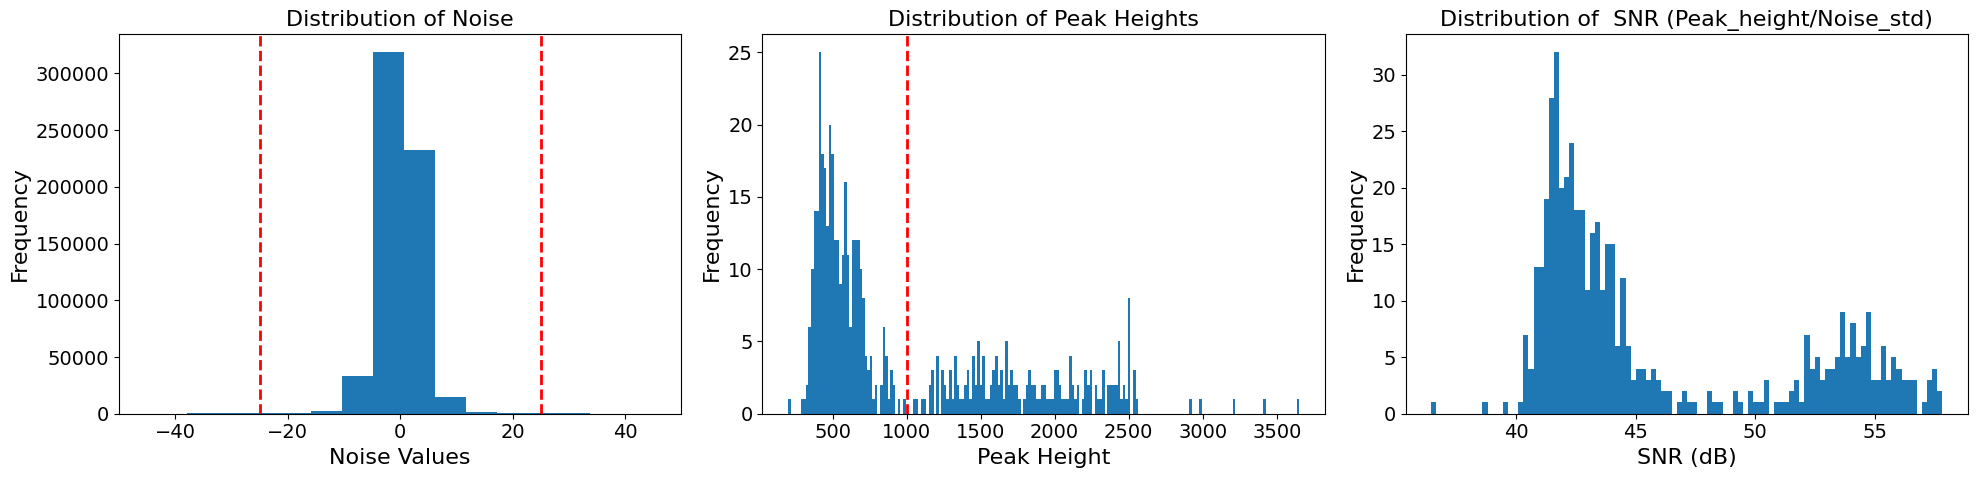

In [7]:
## 3. Generating the Noise distribution, Peak Height Distribution and the SNR distribution

# Number of waveforms 
num_waveforms = 500

# Set the cut-off frequency obtained from above
cut_off = 150

# Initialize lists to store peak heights, noise values, and SNR values
peak_heights = []
noise_values = []
snr_values = []

# Figure for plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for file_name in file_names:
    with h5py.File(file_name, 'r') as f:
        rxwave = f['RXWAVE'][:num_waveforms]
        sigmean = f['SIGMEAN'][:num_waveforms]

    for i in range(num_waveforms):
        
        # Select the waveform
        waveform = rxwave[i]

        # Get the SIGMEAN level
        sigmean_level = sigmean[i]

        # Subtract the SIGMEAN level from the waveform
        waveform_zeroed = waveform - sigmean_level

        # Convert the waveform to the frequency domain using FFT
        waveform_fft = fft(waveform_zeroed)

        # Zero out the FFT coefficients above the cut-off frequency
        waveform_fft[cut_off:-cut_off] = 0

        # Convert the filtered FFT back to the time domain using the inverse FFT
        waveform_filtered = ifft(waveform_fft)

        # Calculate the noise waveform
        noise_waveform = waveform_zeroed - waveform_filtered

        # Append the noise values to the list
        noise_values.extend(noise_waveform.real)
        
        # Calculate the peak height and append it to the list
        peak_height = np.abs(np.max(waveform_filtered)) - np.abs(np.min(waveform_filtered))
        peak_heights.append(peak_height)
        
        # Calculate the noise standard deviation (noise power)
        noise_std = np.std(noise_waveform)
        
        # Calculate SNR (Peak-to-Peak Signal / Standard Deviation of Noise)
        snr = peak_height / noise_std
        snr_dB = 20 * np.log10(snr)  # Convert SNR to dB
        snr_values.append(snr_dB)

# Convert lists to numpy arrays
peak_heights = np.array(peak_heights)
noise_values = np.array(noise_values)
snr_values = np.array(snr_values)

# Plot the noise distribution
axs[0].hist(noise_values, bins=100)
axs[0].set_title('Distribution of Noise')
axs[0].set_xlabel('Noise Values')
axs[0].set_ylabel('Frequency')
axs[0].axvline(-25, color='red', linestyle='dashed', linewidth=2)
axs[0].axvline(25, color='red', linestyle='dashed', linewidth=2)
axs[0].set_xlim(-50, 50)

# Plot the peak height distribution
axs[1].hist(peak_heights, bins=200)
axs[1].set_title('Distribution of Peak Heights')
axs[1].set_xlabel('Peak Height')
axs[1].set_ylabel('Frequency')
axs[1].axvline(1000, color='red', linestyle='dashed', linewidth=2)

# Plot the SNR distribution
axs[2].hist(snr_values, bins=100)
axs[2].set_title('Distribution of  SNR (Peak_height/Noise_std)')
axs[2].set_xlabel('SNR (dB)')
axs[2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [8]:
## 4. Save the noise distribution (Amplitudes) and Peak height distribution based on the cut-off user wants to use.

# # Noise distribution
# noise_values_array = np.array([value for value in noise_values if -50 <= value <= 50])
# np.savetxt('lvis_noise_values.txt', noise_values_array, header = 'Bioscape Campaign: LVIS waveform noise values')

# # Height Distribution
# peak_height_array = np.array([value for value in peak_heights if value <= 1000])
# np.savetxt('lvis_peakHeight_values.txt', peak_height_array, header = 'Bioscape Campaign: LVIS peak height distribution')

"""
We will be using this generated noise distribution and peak height distribution to add noise to the simulated lidar waveforms. Users can directly use the already
generated noise and peak height distribution files or can tweak this program as per their need!!

"""

'\nWe will be using this generated noise distribution and peak height distribution to add noise to the simulated lidar waveforms. Users can directly use the already\ngenerated noise and peak height distribution files or can tweak this program as per their need!!\n\n'